# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec


from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [2]:
# Run this cell to load the dataset

train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [3]:
# Extract train and test images and labels.

train_images = train['X']
train_labels = train['y']  
test_images = test['X']  
test_labels = test['y']

print(f"Shape of Train Images : {train_images.shape}")
print(f"Shape of Train Labels : {train_labels.shape}")

print(f"Shape of Test Images : {test_images.shape}")
print(f"Shape of Test Labels : {test_labels.shape}")

# Images have shape (height, width, channels, num_samples)
# shape required for Tensorflow : (num_sample, height, width, channels)

train_images = np.transpose(train_images, (3, 0, 1, 2))
test_images = np.transpose(test_images, (3, 0, 1, 2))

# 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10.
# Convert label 10 ---> Label 0 for digit 0

train_labels = np.where(train_labels == 10, 0, train_labels)
test_labels = np.where(test_labels == 10, 0, test_labels)

Shape of Train Images : (32, 32, 3, 73257)
Shape of Train Labels : (73257, 1)
Shape of Test Images : (32, 32, 3, 26032)
Shape of Test Labels : (26032, 1)


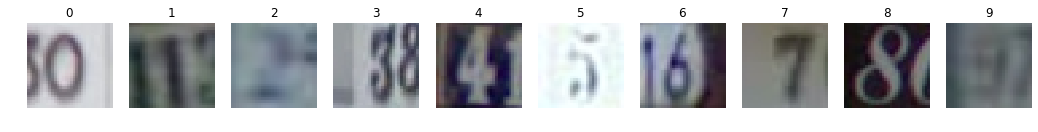

In [4]:
# Plot 10 random images, one image for each digit.

fig, axes = plt.subplots(1,10, figsize=(18,2))
for i, ax in enumerate(axes):
    # filter the data for each number before selecting one random image
    matching_indices = np.where(train_labels[:, 0] == i)[0]
    rand_i = random.choice(matching_indices)
    ax.imshow(train_images[rand_i, :, :, :])
    ax.set_title(train_labels[rand_i, :][0], fontsize=12)
    ax.axis('off')

In [5]:
# Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
# Normalize the values for train and test images.
scaled_train_images = np.mean(train_images, axis=3, keepdims=True) / 255.0
scaled_test_images = np.mean(test_images, axis=3, keepdims=True) / 255.0


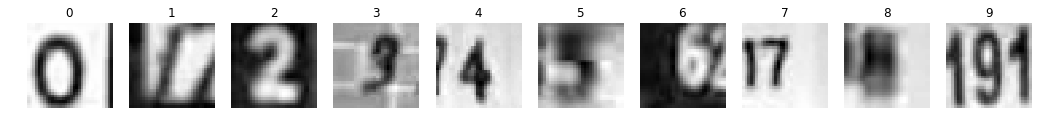

In [6]:
# Plot 10 random images, one image for each digit.

fig, axes = plt.subplots(1,10, figsize=(18,2))
for i, ax in enumerate(axes):
    matching_indices = np.where(test_labels[:, 0] == i)[0]
    # filter the data for each number before selecting one random image
    rand_i = random.choice(matching_indices)
    ax.imshow(scaled_test_images[rand_i, :, :, 0], cmap = "gray")
    ax.set_title(test_labels[rand_i, :][0], fontsize=12)
    ax.axis('off')



## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [7]:
def get_checkpoint_best_only(model_name):
    '''
    Save weights for the model with best validation accuracy
    '''
    checkpoint_path = 'checkpoints_' + model_name + '/checkpoint'
    checkpoint = ModelCheckpoint(filepath = checkpoint_path,
                                 save_weights_only = True,
                                 save_freq= 'epoch',
                                 monitor = 'val_accuracy',
                                 mode = "max",
                                 save_best_only = True,
                                 verbose = 1
                                 )
    return checkpoint

def get_early_stopping():
    '''
    Stop training if validation accupacy does not improve for 3 epochs
    '''
    return EarlyStopping(monitor = "val_accuracy", patience = 3)

class myCallback(tf.keras.callbacks.Callback):
    '''
    Halts the training when loss falls below 0.8
    '''
    def __init__(self, early_stop_loss):
        super().__init__()
        self.early_stop_loss = early_stop_loss 
    def on_epoch_end(self, epoch, logs = None):
        if logs["loss"] < self.early_stop_loss:
            print(f"Loss is below {self.early_stop_loss} as per requirement, cancelling training!")
            self.model.stop_training = True

In [8]:
def plot_loss_accuracy_plots(history_df):
    '''
    Plots training/validation loss and accuracy vs. epoch from a DataFrame using two side-by-side subplots.
    Args: history_df (DataFrame) with columns 'loss', 'val_loss', 'accuracy', 'val_accuracy'.
    '''
    fig, axes = plt.subplots(1,2, figsize = (10,5))

    axes[0].plot(history_df["loss"], label="Training Loss", color="blue")
    axes[0].plot(history_df["val_loss"], label="Validation Loss", color="orange")
    axes[0].set_title("Loss vs. Epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(history_df["accuracy"], label="Training Accuracy", color="blue")
    axes[1].plot(history_df["val_accuracy"], label="Validation Accuracy", color="orange")
    axes[1].set_title("Accuracy vs. Epoch")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    
    return

In [9]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
acc= "accuracy"

def mlp_model(input_shape):
    '''
    Creates a compiled Keras Sequential MLP model with five dense layers for classification.
    Args: input_shape (tuple). 
    Returns: Compiled model with softmax output for 10 classes.
    '''
    model = Sequential([
        Flatten(input_shape=input_shape, name = "flat_1"),  
        Dense(128, activation='relu', name = "dense_1"), 
        Dense(128, activation='relu', name = "dense_2"),
        Dense(64, activation='relu', name = "dense_3"),
        Dense(10, activation='softmax', name = "dense_4")
        ])
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=[acc])
    return model

#kernel_regularizer = regularizers.l1_l2(wd), bias_initializer = "ones", 

In [10]:
checkpoint_best_only = get_checkpoint_best_only("mlp")
early_stopping = get_early_stopping()

In [11]:
model = mlp_model(scaled_train_images[0].shape)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flat_1 (Flatten)             (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 156,618
Trainable params: 156,618
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop_loss = 0.8

history_mlp = model.fit(scaled_train_images, 
                        train_labels,
                        epochs=30,
                        batch_size=256,
                        validation_split = 0.2,
                        callbacks=[checkpoint_best_only, early_stopping, myCallback(early_stop_loss)])

Train on 58605 samples, validate on 14652 samples
Epoch 1/30
58368/58605 [============================>.] - ETA: 0s - loss: 2.2387 - accuracy: 0.1873
Epoch 00001: val_accuracy improved from -inf to 0.21110, saving model to checkpoints_mlp/checkpoint
58605/58605 [==============================] - 15s 250us/sample - loss: 2.2381 - accuracy: 0.1877 - val_loss: 2.1985 - val_accuracy: 0.2111
Epoch 2/30
58368/58605 [============================>.] - ETA: 0s - loss: 1.8928 - accuracy: 0.3442
Epoch 00002: val_accuracy improved from 0.21110 to 0.44438, saving model to checkpoints_mlp/checkpoint
58605/58605 [==============================] - 12s 213us/sample - loss: 1.8916 - accuracy: 0.3447 - val_loss: 1.6229 - val_accuracy: 0.4444
Epoch 3/30
58112/58605 [============================>.] - ETA: 0s - loss: 1.3806 - accuracy: 0.5518
Epoch 00003: val_accuracy improved from 0.44438 to 0.58026, saving model to checkpoints_mlp/checkpoint
58605/58605 [==============================] - 12s 207us/sample 

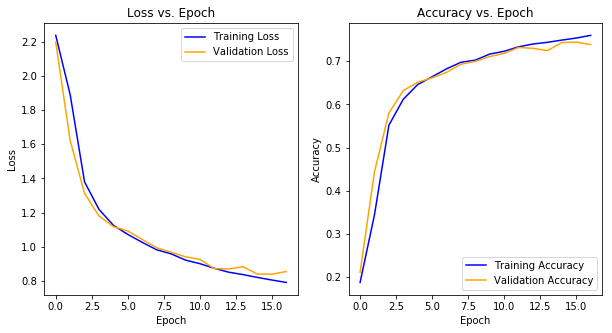

In [13]:
plot_loss_accuracy_plots(pd.DataFrame(history_mlp.history))

In [14]:
# Load the checkpoint with best Validation Accuracy and compare loss and accuracy on train and test dataset.
del model
mlp_checkpoint_path = 'checkpoints_mlp/checkpoint'
model = mlp_model(scaled_train_images[0].shape)
model.load_weights(mlp_checkpoint_path)

MLP_train_loss, MLP_train_accuracy = model.evaluate(scaled_train_images, train_labels, verbose = 0)
MLP_test_loss, MLP_test_accuracy = model.evaluate(scaled_test_images, test_labels, verbose = 0)

In [15]:
print(f"Train Loss = {MLP_train_loss:.2f}\nTrain Accuracy = {MLP_train_accuracy:.2f}")
print(f"Testing Loss = {MLP_test_loss:.2f}\nTesting Accuracy = {MLP_test_accuracy:.2f}")

Train Loss = 0.80
Train Accuracy = 0.76
Testing Loss = 0.94
Testing Accuracy = 0.73


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
acc= "accuracy"

def cnn_model(input_shape, rate = 0, l1_regularizer = 0):
    '''
    Builds a CNN model with two convolutional layers, max pooling, and dense layers for classification.
    Args: input_shape (tuple), rate (float, dropout rate), l1_regularizer (float, L1 regularization). 
    Returns: Compiled model with softmax output for 10 classes.
    '''
    model = Sequential([
        Conv2D(16, kernel_size = (2,2), activation = "relu",  input_shape = input_shape, name = "conv_1"),
        MaxPooling2D(pool_size=(2,2), name = "pool_1"),
        Conv2D(16, kernel_size = (2,2), activation = "relu",  input_shape = input_shape, name = "conv_2"),
        MaxPooling2D(pool_size=(2,2), name = "pool_2"),
        Flatten(name = "flatten"),
        Dense(64, activation = "relu", kernel_regularizer = regularizers.l1(l1_regularizer), bias_initializer = "ones", name = "dense_1"),
        Dropout(rate),
        Dense(32, activation = "relu", kernel_regularizer = regularizers.l1(l1_regularizer), bias_initializer = "ones", name = "dense_2"),
        Dropout(rate),
        Dense(10, activation = "softmax", name = "dense_3")
        ])
    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=[acc])
    return model

In [17]:
checkpoint_best_only = get_checkpoint_best_only("cnn")
early_stopping = get_early_stopping()

In [18]:
dropout_rate = 0.1
l1_regularizer = 1e-4

model = cnn_model(scaled_train_images[0].shape, dropout_rate, l1_regularizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 31, 31, 16)        80        
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 15, 15, 16)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 16)        1040      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

In [19]:
early_stop_loss = 0.8

history_cnn = model.fit(scaled_train_images, 
                        train_labels, 
                        epochs=30,
                        batch_size=256,
                        validation_split = 0.2,
                        callbacks=[checkpoint_best_only, early_stopping, myCallback(early_stop_loss)])

Train on 58605 samples, validate on 14652 samples
Epoch 1/30
58368/58605 [============================>.] - ETA: 0s - loss: 2.4649 - accuracy: 0.1669
Epoch 00001: val_accuracy improved from -inf to 0.18748, saving model to checkpoints_cnn/checkpoint
58605/58605 [==============================] - 103s 2ms/sample - loss: 2.4644 - accuracy: 0.1671 - val_loss: 2.3223 - val_accuracy: 0.1875
Epoch 2/30
58368/58605 [============================>.] - ETA: 0s - loss: 2.1939 - accuracy: 0.2585
Epoch 00002: val_accuracy improved from 0.18748 to 0.42206, saving model to checkpoints_cnn/checkpoint
58605/58605 [==============================] - 102s 2ms/sample - loss: 2.1926 - accuracy: 0.2591 - val_loss: 1.8388 - val_accuracy: 0.4221
Epoch 3/30
58368/58605 [============================>.] - ETA: 0s - loss: 1.6405 - accuracy: 0.4972
Epoch 00003: val_accuracy improved from 0.42206 to 0.63623, saving model to checkpoints_cnn/checkpoint
58605/58605 [==============================] - 102s 2ms/sample - l

In [20]:
# Load the checkpoint with best Validation Accuracy and compare loss and accuracy on train and test dataset.

del model
cnn_checkpoint_path = 'checkpoints_cnn/checkpoint'
model = cnn_model(scaled_train_images[0].shape)
model.load_weights(cnn_checkpoint_path)

CNN_train_loss, CNN_train_accuracy = model.evaluate(scaled_train_images, train_labels, verbose = 0)
CNN_test_loss, CNN_test_accuracy = model.evaluate(scaled_test_images, test_labels, verbose = 0)

In [21]:
print(f"Training Loss = {CNN_train_loss:.2f}\nTraining Accuracy = {CNN_train_accuracy:.2f}")
print(f"Testing Loss = {CNN_test_loss:.2f}\nTesting Accuracy = {CNN_test_accuracy:.2f}")


Training Loss = 0.52
Training Accuracy = 0.84
Testing Loss = 0.61
Testing Accuracy = 0.82


In [22]:
!ls -lh checkpoints_mlp

total 1.9M
-rw-r--r-- 1 jovyan users   77 Apr  3 20:59 checkpoint
-rw-r--r-- 1 jovyan users 1.8M Apr  3 20:59 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.0K Apr  3 20:59 checkpoint.index


In [23]:
!ls -lh checkpoints_cnn

total 644K
-rw-r--r-- 1 jovyan users   77 Apr  3 21:17 checkpoint
-rw-r--r-- 1 jovyan users 635K Apr  3 21:17 checkpoint.data-00000-of-00001
-rw-r--r-- 1 jovyan users 2.4K Apr  3 21:17 checkpoint.index


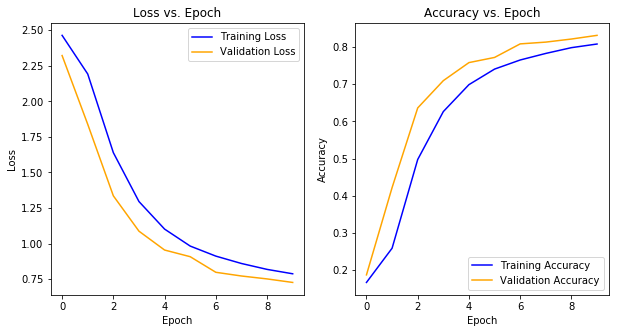

In [24]:
plot_loss_accuracy_plots(pd.DataFrame(history_cnn.history))

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

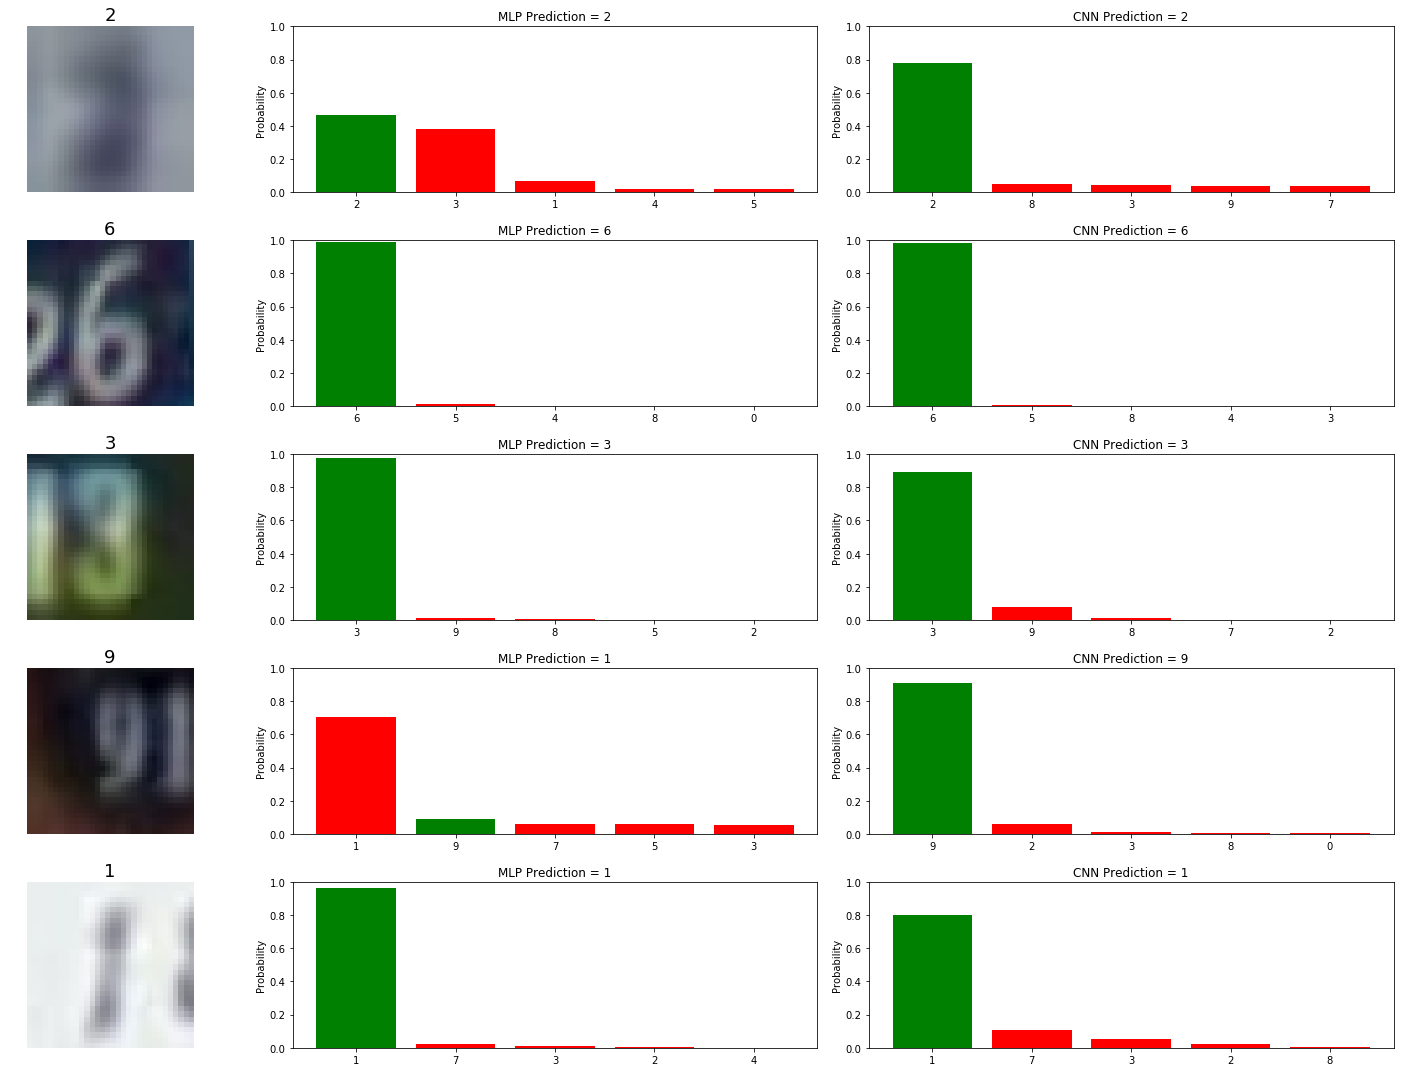

In [28]:
#del mlp_model
#del cnn_model

mlp_checkpoint_path = 'checkpoints_mlp/checkpoint'

mlp_model_pred = mlp_model(scaled_train_images[0].shape)
mlp_model_pred.load_weights(mlp_checkpoint_path)

cnn_checkpoint_path = 'checkpoints_cnn/checkpoint'
cnn_model_pred = cnn_model(scaled_train_images[0].shape)
cnn_model_pred.load_weights(cnn_checkpoint_path)


fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(5, 3, width_ratios=[1,2,2])
axes = [[fig.add_subplot(gs[i, j]) for j in range(3)] for i in range(5)]

for i in range(5):
    # Select a random image and plot
    img_idx = np.random.choice(test_images.shape[0])
    axes[i][0].imshow(test_images[img_idx, :, :, :])
    axes[i][0].set_title(test_labels[img_idx, :][0], fontsize=18)
    axes[i][0].axis('off') 
    axes[i][0].set_aspect('equal') 
    axes[i][0].autoscale(enable=True, axis='both', tight=True)
    
    image = (scaled_test_images[img_idx])[np.newaxis, ...]
    
    # MLP Model
    
    # Get prediction for the image
        
    predictions_mlp = mlp_model_pred.predict(image)
    predictions_mlp = predictions_mlp[0] 
    top_5_indices_mlp = np.argsort(-predictions_mlp)[:5]
    top_5_probs_mlp = predictions_mlp[top_5_indices_mlp]  
    top_5_labels_mlp = [str(i) for i in top_5_indices_mlp] 
    
    # Bar color selection
    colors_mlp = []
    for j in range(5):
        if top_5_indices_mlp[j] == test_labels[img_idx, :][0]:
            colors_mlp.append("green")
        else:
            colors_mlp.append("red")
    
    # Plot top 5 prediction
    axes[i][1].bar(top_5_labels_mlp, top_5_probs_mlp, color = colors_mlp)
    axes[i][1].set_ylim(0, 1)
    axes[i][1].set_ylabel("Probability")
    axes[i][1].set_title(f"MLP Prediction = {top_5_labels_mlp[0]}")
    
    
    # CNN Model
    
    # Get prediction for the image
    predictions_cnn = cnn_model_pred.predict(image)
    predictions_cnn = predictions_cnn[0] 
    top_5_indices_cnn = np.argsort(-predictions_cnn)[:5]
    top_5_probs_cnn = predictions_cnn[top_5_indices_cnn]  
    top_5_labels_cnn = [str(i) for i in top_5_indices_cnn] 
    
    # Bar color selection
    colors_cnn = []
    for j in range(5):
        if top_5_indices_cnn[j] == test_labels[img_idx, :][0]:
            colors_cnn.append("green")
        else:
            colors_cnn.append("red")
    
    # Plot top 5 prediction
    axes[i][2].bar(top_5_labels_cnn, top_5_probs_cnn, color = colors_cnn)
    axes[i][2].set_ylim(0, 1)
    axes[i][2].set_ylabel("Probability")
    axes[i][2].set_title("CNN Prediction")
    axes[i][2].set_title(f"CNN Prediction = {top_5_labels_cnn[0]}")
    
plt.tight_layout()
plt.show()